## Frequency analysis of discrete-time signals

With our newly discretized signals, we'll also have to obtain a discrete version of the Fourier transform as well and that will be our departure point for doing fundamental frequency analysis in practice. We'll also discuss the concept of power spectral density (PSD) and demonstrate its usefulness with a few examples. There are several concepts to be digested, so let's jump into it!

In [ ]:
# Installing the packages
%pip install ipympl
import numpy as np 
import matplotlib
if not hasattr(matplotlib.RcParams, "_get"):
    matplotlib.RcParams._get = dict.get
from scipy import signal
import io
from scipy.io import wavfile
from pyodide.http import pyfetch
from matplotlib import pyplot as plt
from ipywidgets import * # interactive plots
import IPython
from IPython.display import Audio, Image
%matplotlib ipympl

# function for reading WAV files from a URL. Must be a RAW link, not GitHub HTML
vocal_sample = "https://raw.githubusercontent.com/randyaliased/acspjbook/main/book/audio/vocal_sample.wav"

async def read_wav_from_url(url):
    response = await pyfetch(url)
    wav_bytes = await response.bytes()  # get raw binary
    fs, data = wavfile.read(io.BytesIO(wav_bytes))

    # convert to float in [-1, 1]
    if np.issubdtype(data.dtype, np.integer):
        max_val = np.iinfo(data.dtype).max
        data = data.astype(np.float32) / max_val
    else:
        data = data.astype(np.float32)  # already float
    
    return data, fs

### Discrete-Time Fourier Transform (DTFT)

Let's recall the Fourier transform analysis equation for continuous-time signals. Instead of writing it in terms of $\omega$ as we did [before](https://randyaliased.github.io/acspjbook/main/fundamental/05_Fourier_Transform.html), we'll express it directly in terms of the frequency $f$ in Hz by substituting $\omega = 2 \pi f$:

$$\begin{align} 
	X(f) &=\int_{-\infty}^{\infty}x(t)e^{-j 2 \pi f t}\text{d}t
\end{align}$$

Now that we are dealing with discrete-time signals, there are a few modifications to be made to this formula:
1. The continuous-time variable, $t$, is to be replaced with the discretised version, $n T_s$, where $T_s$ is the sampling period for $n = 0, 1, 2, \dots$. 
2. We replace the integral with a summation.

This leads us to the **discrete-time Fourier transform (DTFT)**:

$$\begin{align} 
	X(f) &=\sum\limits_{n=-\infty}^{\infty}x(nT_s)e^{-j 2 \pi f n T_s} = \sum\limits_{n=-\infty}^{\infty}x[n]e^{-j 2 \pi f n T_s} = \sum\limits_{n=-\infty}^{\infty}x[n]e^{-j \frac{2 \pi f}{f_s} n}
\end{align}$$

In the last equation, we simply substituted $T_s = 1/f_s$, where $f_s$ is the sampling frequency. In some literature, you will find the term $\Omega = (2 \pi f)/(f_s)$ being used, which is simply a normalized angular frequency (sometimes called a digital frequency) which ranges from $0$ to $2 \pi$. Note in these equations that we have also omitted the $dt$ variable. In the discrete-time domain, this corresponds to $T_s$ and hence only contributes to a scaling, but we'll come back to that later. In any case, we have a version of the Fourier transform that can analyze discrete-time signals. It is, however, of limited use in practice since the left-hand-side of the equation is still continuous in terms of frequency, $f$, i.e., we can obtain the Fourier coefficients at any frequency, f. While that may seem advantageous, as we want to be able to process our signals with computers, it will be more convenient to have a discrete form of the spectrum as well, which carries us over into the **discrete Fourier transform (DFT)**.


### Discrete Fourier Transform (DFT)

Let's make a few modifications to the DTFT:
1. Usually when we take a recording of some signal, we have a finite number of samples, $N$. So let's constrain the limits of the summation to go from $0$ to $N-1$.
2. Let's sample the continuous spectrum. In a similar way to how we sampled time, we sample the frequency axis by replacing $f = k \Delta f$, where $\Delta f$ is a constant spacing between frequency values and k is an integer such that $k = 0, 1, 2, … N-1$.

This results in

$$\begin{align} 
	X[k \Delta f] &= \sum\limits_{n=0}^{N-1}x[n]e^{-j 2 \pi k \Delta f n T_s} 
\end{align}$$

Let's pause for a second and make sure we understand this. If our signal contained $N=1000$ samples and we were to choose $\Delta f = 10$ Hz, then the values of $k = 0, 1, 2, … N-1$ would correspond to the discrete frequencies $\{0, 10, 20, \dots 9990\}$ Hz, and these are the frequencies at which we would obtain the complex values of the Fourier coefficients (the result of the summation). The integer values of $k$ are commonly referred to as **frequency bins**. 

We, however, cannot typically just choose values for $\Delta f$ as they are constrained by the following relationship, i.e., $\Delta f$ is fixed for some given $f_s$ and $N$:

$$\begin{equation}
\Delta f \hspace{0.1cm} T_s = \frac{1}{N}  \rightarrow \Delta f  = \frac{f_s}{N}
\end{equation}$$

Substitution of this expression into the previous equation finally brings us to the discrete Fourier transform (DFT) analysis equation:

$$\begin{align} 
	X[k] &= \sum\limits_{n=0}^{N-1}x[n]e^{-j \frac{2 \pi}{N} k  n} \\
         &= x[0] + x[1]e^{-j \frac{2 \pi k}{N}} + x[1]e^{-j \frac{2 \pi k}{N} 2} + \dots + x[N-1]e^{-j \frac{2 \pi k}{N} (N-1)}
\end{align}$$

We have dropped the dependence on $\Delta f$ on the left-hand-side as it is constant (similar to how we dropped $T_s$ for discrete-time signals). For each value of $k = 0, 1, 2, … N-1$ (for each corresponding frequency), we can interpret this equation as a sum of complex exponentials with normalized frequencies $(2 \pi k)/N = (2 \pi k \Delta f)/f_s$, weighted by the values in $x[n]$ (amplitudes of the signal).  This results in a complex number for each frequency from which we can compute the magnitude and phase, and where the square of the magnitude tells use something about how much energy there is in the signal at that particular frequency. (I hope this is all starting to connect with everything we've done so far!).

And of course, we also have the **inverse DFT** (synthesis equation), which for $n = 0, 1, 2, … N-1$, is given by (think about how this relates to the [Fourier series](https://randyaliased.github.io/acspjbook/main/fundamental/04_Fourier_Series.html))

$$\begin{align} 
	x[n] &= \frac{1}{N}\sum\limits_{k=0}^{N-1}X[k]e^{j \frac{2 \pi}{N} k  n} \hspace{0.4 cm} 
\end{align}$$

Let's do a really simple example just to get an idea of how the DFT works.

In [35]:
# Define a simple array of values to represent x[n]
x = np.array([-0.2, 0.4, 0.3, -1.5])
N = len(x) # number of points in x

print("x[n] =", x)
# Lets implement the DFT formula in Python 
X = np.zeros(N, dtype='complex') # Define an array to hold the DFT values (same length as x)

# We can implement the formula using two for loops (inefficient but it helps to illustrate the concept)
for k in range(N):
    print ("k =", k)
    for n in range(N):
        print ("  n =", n," -->  x[n]*exp_term =", x[n],"*", np.exp((-1j*2*np.pi*k*n)/N))
        X[k] += x[n]*np.exp((-1j*2*np.pi*k*n)/N)
        if n == N-1:
            print ("    Summing these components, X[",k,"] =", X[k])


x[n] = [-0.2  0.4  0.3 -1.5]
k = 0
  n = 0  -->  x[n]*exp_term = -0.2 * (1+0j)
  n = 1  -->  x[n]*exp_term = 0.4 * (1+0j)
  n = 2  -->  x[n]*exp_term = 0.3 * (1+0j)
  n = 3  -->  x[n]*exp_term = -1.5 * (1+0j)
    Summing these components, X[ 0 ] = (-1+0j)
k = 1
  n = 0  -->  x[n]*exp_term = -0.2 * (1+0j)
  n = 1  -->  x[n]*exp_term = 0.4 * (6.123233995736766e-17-1j)
  n = 2  -->  x[n]*exp_term = 0.3 * (-1-1.2246467991473532e-16j)
  n = 3  -->  x[n]*exp_term = -1.5 * (-1.8369701987210297e-16+1j)
    Summing these components, X[ 1 ] = (-0.4999999999999997-1.9000000000000001j)
k = 2
  n = 0  -->  x[n]*exp_term = -0.2 * (1+0j)
  n = 1  -->  x[n]*exp_term = 0.4 * (-1-1.2246467991473532e-16j)
  n = 2  -->  x[n]*exp_term = 0.3 * (1+2.4492935982947064e-16j)
  n = 3  -->  x[n]*exp_term = -1.5 * (-1-3.6739403974420594e-16j)
    Summing these components, X[ 2 ] = (1.2+5.755839955992561e-16j)
k = 3
  n = 0  -->  x[n]*exp_term = -0.2 * (1+0j)
  n = 1  -->  x[n]*exp_term = 0.4 * (-1.8369701987210297

### Defining the frequencies

Hopefully this gave an idea of how the DFT analysis equation works. From a discrete-time signal with $N=4$ values, we obtained a corresponding $N=4$ complex values from our DFT for $k = 0, 1, 2, 3$. As mentioned before, this means that we can plot both the magnitude and phase of the signal. However, we need to know what frequency each of these values of $k$ corresponds to. Luckily, we already saw that simply multiplying $k \Delta f$ for $k = 0, 1, 2, \dots N-1$ will convert the frequency bins to frequency in Hz, 
where $\Delta f$ is the spacing between the sampled frequencies and hence is also referred to as the bin spacing or may be thought of as a frequency resolution.

Recall that we could not freely choose $\Delta f$ and it was defined as  $\Delta f = f_{s}/N$. Hence the corresponding frequency array for the DFT is given by

$$\begin{equation}
\frac{k f_{s}}{N}, \hspace{0.3cm} k = 0, 1, 2, \dots N-1
\end{equation}$$

which corresponds to frequencies from 0 Hz to $(f_{s}-df)$ Hz. 

It's worth a moment to ponder on the equation $\Delta f = f_{s}/N$ as it has profound consequences. Essentially it tells us that once we have chosen $f_s$ (usually dictated by your sound card), and a number of samples to analyse in our signal, $N$, then your frequency resolution, $\Delta f$ is already set. The only way we can increase our frequency resolution is therefore either by reducing the sampling frequency or by including more samples in our signal to analyze (if they exist). These choices do not come without consequences however. When increasing the number of samples, it means that we lose some temporal resolution of the signal (as we will see in [Time-Frequency analysis](https://randyaliased.github.io/acspjbook/main/fundamental/08_Time_Freq_Analysis.html)). And if we alternatively reduce the sampling frequency, although we increase the resolution, we will reduce the maximum frequency up to which we have information and depending on our soundcard, we can run into aliasing artifacts (recall the Nyquist-Shannon sampling theorem from the whistling demo!).

To continue to get a feel for all of this, let's perform the DFT on another simple array of values, define the frequency array, and plot the magnitude spectrum. We can also plot the phase spectrum, but we'll focus on the magnitude spectrum for now (feel free to modify the code to plot the phase of course!). 

Sampling frequency fs = 1000 Hz
DFT values:
k = 0  --> f = 0.0 Hz and X[ 0 ] = (0.4+0j)
k = 1  --> f = 125.0 Hz and X[ 1 ] = (1.0091883092036782+0.8849242404917501j)
k = 2  --> f = 250.0 Hz and X[ 2 ] = (0.49999999999999983-1.1j)
k = 3  --> f = 375.0 Hz and X[ 3 ] = (-2.8091883092036785+2.0849242404917496j)
k = 4  --> f = 500.0 Hz and X[ 4 ] = (0.5999999999999998-1.347111479062088e-16j)
k = 5  --> f = 625.0 Hz and X[ 5 ] = (-2.809188309203675-2.084924240491753j)
k = 6  --> f = 750.0 Hz and X[ 6 ] = (0.49999999999999833+1.100000000000001j)
k = 7  --> f = 875.0 Hz and X[ 7 ] = (1.0091883092036806-0.8849242404917481j)


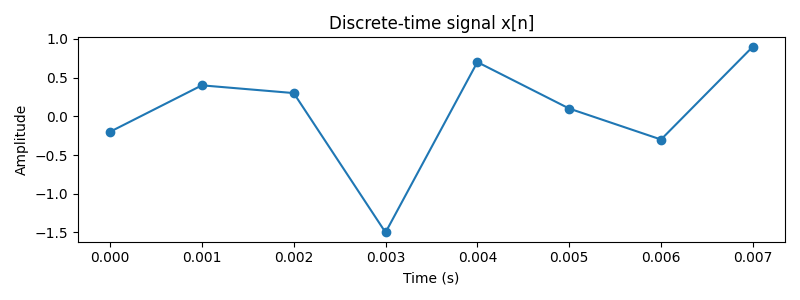

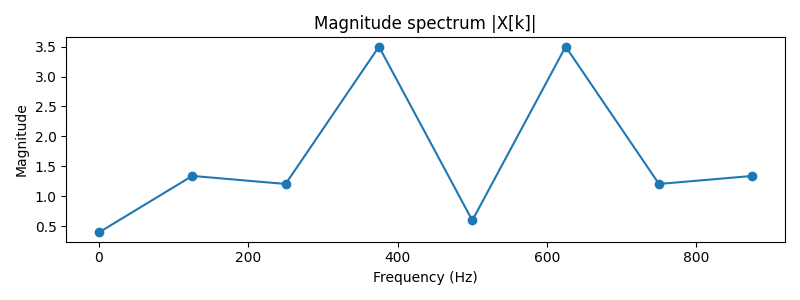

In [ ]:
fs = 1000   # let's assume some sampling frequency in Hz

# Define a simple array of values to represent x[n]x
x = np.array([-0.2, 0.4, 0.3, -1.5, 0.7, 0.1, -0.3, 0.9])
t = np.arange(0,len(x),1)*(1/fs) # array of discrete time values (recall T_s = 1/fs and each time step is n.T_s)
N = len(x) # number of points in x

# plot the discrete-time signal
fig, ax = plt.subplots(2,1)    
ax[0].plot(t, x, '-o')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')
ax[0].set_title('Discrete-time signal x[n]')
plt.tight_layout()

# Do the DFT
X = np.zeros(N, dtype='complex') # Define an array to hold the DFT values (same length as x)
# Define the frequency array
delta_f = fs/N # frequency resolution
f = np.arange(0, fs, delta_f) # frequency array 

# We can implement the formula using two for loops (inefficient but it helps to illustrate the concept)
print ("Sampling frequency fs =", fs, "Hz")
print("DFT values:")
for k in range(N):
    for n in range(N):
        X[k] += x[n]*np.exp((-1j*2*np.pi*k*n)/N)
    print ("k =", k, " --> f =", f[k], "Hz and X[",k,"] =", X[k])

# Plot the magnitude spectrum
ax[1].plot(f, np.abs(X), '-o')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Magnitude')
ax[1].set_title('Magnitude spectrum |X[k]|')
plt.tight_layout()

### Periodicity and Symmetry

For this arbitrary signal, the magnitude spectrum is not particularly interesting, but it does illustrate that there is some sort of symmetry which is tied to an inherent periodicity within the DFT. This is due to the complex exponential in the DFT, $e^{\pm j \frac{2 \pi}{N} k  n}$ which is periodic every N samples, such that 

$$\begin{equation}
x[n + N] = x [n];\hspace{0.5cm} X[k+N] = X[k]
\end{equation}$$

meaning that the time segment of $N$ samples and DFT coefficients, also of $N$ samples, are repeated from $-\infty$ to $\infty$ (a god exercise is to try and prove this with the DFT/inverse DFT formulas from above). This is why doing the DFT corresponds to doing a transform not only to a time segment of $N$ samples, but rather a repeated version of that time segment with period, $N$. This has important consequences when considering time windows (which we will briefly discuss in [time-frequency analysis](https://randyaliased.github.io/acspjbook/main/fundamental/08_Time_Freq_Analysis.html)).  

The periodicity of $X[k]$ is something we already came across when we looked at the [spectrum of a sampled signal](https://randyaliased.github.io/acspjbook/main/fundamental/06_Sampling.html#but-why-did-aliasing-occur). Recall that when we sampled in the time-domain, this resulted in a repetition of the spectrum (frequency replicas) around integer multiples of $f_{s}$, accounting for its periodicity. What we're obeserving in the above plot in the section above $f_{s}/2$ is in fact the lower part of the first frequency replica, and hence why we see this symmetry. We can note some very specific characteristics of this symmetry (see the printed values in the previous code cell to verify):

1. For signals with an even number of samples, the symmetry occurs around the value $k = N/2$ which corresponds to a frequency of $k \Delta f = (N/2).(fs/N) = fs/2$, half of the sampling frequency, and what we referred to as the **Nyquist frequency**. 

2. The symmetry is such that $X[k - N] = X^{*}[k]$ for $k = 1, 2, \dots (\frac{N}{2} -1)$, where $X^{*}[k]$ denotes the complex conjugate of $X[k]$. In words, this means that the complex conjugates the values from $k = 1, 2, \dots (\frac{N}{2} -1)$ are reflected around $k = N/2$. (Again have a look at the printed values above to verify).

3. The values of $X[k]$ for $k=0$ and $k=N/2$ are unique (i.e., not repeated) and real-valued.

This leads us to the concept of the **one-sided spectrum**. Given that there is only unique information up to $k=N/2$, i.e, up to the Nyquist frequency, $f_s/2$, we typically only observe the information of "one side" of the spectrum, i.e., up to this Nyquist frequency. We will formalize this a bit more shortly, but let's start working with a real audio signal and finally do a bit of audio analysis.


### Fast Fourier Transform (FFT)

I have been implementing a very inefficient (and slow) DFT by using two for loops. The fast Fourier transform (FFT) on the other hand, (as the name implies) is a fast algorithm that is [notorious](https://www.youtube.com/watch?v=nmgFG7PUHfo) for implementing a Discrete Fourier Transform (DFT). In Python and many other programming languages, there are [pre-defined packages](https://numpy.org/doc/stable/reference/routines.fft.html) which compute the FFT for us and we'll use that. I'm not going to go into details of the FFT as we've covered the underlying principles of the DFT it's implementing. But if you are interested, have a look at (PUT REF).

Let's perform the FFT on a vocal sample, and plot the one-sided magnitude spectrum. We can plot the phase spectrum, but it may not be particularly interesting. (In case you are curious, [here](https://antieverything.bandcamp.com/track/black-stripe) is where vocal sample stem comes from.) We can see that there is quite a bit of signal energy concentrated below $2$ kHz. 

In [ ]:
# Let's import the vocal sample and plot it (a discrete-time signal x[n])
yy, fs = await read_wav_from_url(vocal_sample) # read in the vocal sample and get its sampling frequency
if len(yy) % 2 != 0: yy = yy[:-1] # remove the last sample to make it even

t = np.arange(0,len(yy),1)*(1/fs) # array of discrete time values
N = len(yy) # number of samples in the signal
print("Sampling frequency fs =", fs, "Hz")
print("Nyquist frequency fs/2 =", fs/2, "Hz")
print("Number of samples N =", N)

IPython.display.display(Audio(yy.T, rate=fs))
      
fig, axes = plt.subplots(2,1) 
axes[0].plot(t, yy)
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')

# Let's compute the DFT of the vocal sample and plot the magnitude spectrum
X = np.fft.fft(yy) # compute the DFT using the FFT algorithm  

# Define the frequency array
df = fs/N # frequency resolution
f = np.arange(0,N,1)*df     # frequency array from 0 to fs 

# Plot the magnitude spectrum
axes[1].plot(f, np.abs(X))
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Magnitude')
axes[1].set_xlim([0, fs/2])
plt.tight_layout()
plt.show()


UnboundLocalError: local variable '_jsfetch' referenced before assignment

### Power Spectral Density

#### Energy equivalence

So far we've simply been observing the magnitude of the DFT coefficients across frequency, but having a quantity that is representative of the distribution of power across frequency can be of more practical use. For instance such a quantity can be used for computing sound pressure levels (SPLs) within certain frequency bands of the spectrum. The **power spectral density (PSD)** is one such quantity and is defined such that the integral of the PSD across all frequencies is equal to the mean-square value of the signal in the time domain. 

For a continuous-time domain signal, $x(t)$, its mean-square value, ${x}_{ms}$, is a measure of its average power of some time, $T$ and is given by

$$\begin{equation}
{x}_{ms} = \frac{1}{T} \int_{0}^{T} x^{2}(t) dt
\end{equation}$$

In order to mathematically define the PSD, we start with Parseval's theorem (or the more general [Plancherel_theorem](https://en.wikipedia.org/wiki/Plancherel_theorem) which establishes an energy equivalence in the time and frequency domains such that

$$\begin{equation}
\int_{-\infty}^{\infty} x^{2}(t) dt = \int_{-\infty}^{\infty} |X(f)^{2}| df 
\end{equation}$$

where $|X(f)|$ is the magnitude of the Fourier transform of the continuous-time signal, $x(t)$. 

#### The linear spectrum

We now need to make this equivalence for discrete-time signals and using the DFT. But before we do that, we need to revisit our previous DFT and inverse DFT definitions. The definitions that have been previously presented are quite standard and is what you will find in many classic digital signal processing books (e.g., {cite:p}`Oppenheim2009`). These definitions are in fact so standard that they are the exact formulations implemented in the fft routines of Python and Matlab. However, we need to be attentive to scalings to ensure that we preserve the energy equivalence in the time and frequency domain. Recall that when we were deriving the DFT, we left out the differential, $dt$ from the integral of the continuous-time Fourier transform. This is an important scaling, and we need to include it in order to get to the correct PSD definition. So let's define an alternative version of the DFT analysis equation that accounts for $dt$. We use an alternative symbol, $\tilde{X}[k]$, and refer to this quantity as the **linear spectrum**, defined as

$$\begin{align} 
	\tilde{X}[k] &= \sum\limits_{n=0}^{N-1}x[n]e^{-j \frac{2 \pi}{N} k  n} \hspace{0.2cm} \Delta t
\end{align}$$

where $\Delta t = T_s$ is sampling period (we've used $\Delta t$ as opposed to $T_s$ so as to not confuse the variable $T_s$ with $T$). Note that if you wanted to compute this quantity in Python, you must multiply the output of the np.fft.fft function by $\Delta t$. If you were to compute the linear spectrum of a signal, then to recover the time-domain signal, the appropriate scalings will also need to be incorporated and the inverse DFT becomes

$$\begin{align} 
	x[n] &= \sum\limits_{k=0}^{N-1} \tilde{X}[k] e^{j \frac{2 \pi}{N} k  n} \hspace{0.2cm} \Delta f
\end{align}$$

Again note here that in Python, the np.fft.ifft function implements the previously defined inverse DFT formulation with the $1/N$ scaling. Hence if we were using the np.fft.ifft function with the linear spectrum as defined above, we will need to multiply by $N$ and by $\Delta f$.

#### Deriving the PSD

Okay that was a slight digression, but an important one. In cases when we want accurate quantities, we need to always be attentive to scalings that can skew our answers. With the linear spectrum and its inverse defined, let's continue with our derivation of the PSD. Following from the previous energy equivalence definition, the discrete-time equivalent of Parseval's theorem for a finite-length discrete-time signal, $x[n]$ with $N$ samples is given by

$$\begin{equation}
\sum \limits_{n=0}^{N-1} x^{2}[n] \hspace{0.1cm} \Delta t = \sum \limits_{k=0}^{N-1} |\tilde{X}[k]^{2}| \hspace{0.1cm} \Delta f 
\end{equation}$$

where we note that the linear spectrum, $\tilde{X}[k]$ is on the right-hand-side. And the corresponding mean-square of $x[n]$ becomes

$$\begin{align}
{x}_{ms} = \frac{1}{T} \int_{0}^{T} x^{2}(t) dt \rightarrow \frac{1}{T} \sum \limits_{n=0}^{N-1} x^{2}[n] \hspace{0.1cm} \Delta t &= \frac{1}{N \Delta t} \sum \limits_{n=0}^{N-1} x^{2}[n] \Delta t \\
&= \frac{1}{N} \sum \limits_{n=0}^{N-1} x^{2}[n] 
\end{align}$$

Let's now define the PSD. We denote the PSD by the variable $S_{xx}[k]$ (notation from {cite:p}`bendat2011random`) for $k = 0, 1, 2, \dots N-1$, meaning that it is defined for all frequencies from $0$ Hz up to $f_s - \Delta f$ Hz. As this definition includes the portion of the spectrum that is repeated, we refer to $S_{xx}[k]$ as the **double-sided PSD**. We define it such that we want its sum across all frequencies multiplied by $\Delta f$ to be equal to the mean-square of the time-domain signal, $x[n]$:

$$\begin{align}
\sum \limits_{k=0}^{N-1} S_{xx}[k] \hspace{0.1cm} \Delta f &= \frac{1}{N } \sum \limits_{n=0}^{N-1} x^{2}[n]
\end{align}$$

Substituting the discrete-time formulation of Parseval's theorem from above, we then obtain:

$$\begin{align}
\sum \limits_{k=0}^{N-1} S_{xx}[k] \hspace{0.1cm} \Delta f &= \frac{1}{N } \sum \limits_{n=0}^{N-1} x^{2}[n]  \\
 &= \frac{1}{N \Delta t} \sum \limits_{k=0}^{N-1} |\tilde{X}[k]^{2}| \hspace{0.1cm} \Delta f \\
& = \frac{1}{T} \sum \limits_{k=0}^{N-1} |\tilde{X}[k]^{2}| \hspace{0.1cm} \Delta f 
\end{align}$$

and hence to ensure that the **energy equivalence in both the time and frequency domain is always preserved**, we define the double-sided PSD, $S_{xx}[k]$ as

$$\begin{align}
S_{xx}[k] \hspace{0.1cm} &= \frac{1}{T} |\tilde{X}[k]^{2}|,  \hspace{0.4cm} \text{for} \hspace{0.1cm} k = 0, 1, 2, \dots, N-1
\end{align}$$

As we've seen before, due to the repetition of the spectrum, it's often more useful to work with a single-sided spectrum, hence we can also define a corresponding **single-sided PSD** which we denote as $G_{xx}[k]$. Recall that since it was only the DFT values for $k = 1, 2, \dots (N/2 - 1)$ that were repeated, we need to compensate with a factor of 2. However the DFT values for $k=0$ and $k=N/2$ remain unchanged. Therefore we define the  single-sided PSD, $G_{xx}[k]$ as

$$\begin{align}
G_{xx}[k] \hspace{0.1cm} &= \begin{cases} \frac{1}{T} |\tilde{X}[k]^{2}|,  \hspace{0.4cm} \text{for} \hspace{0.1cm} k = 0, N/2 \\ 
 \frac{2}{T} |\tilde{X}[k]^{2}|,  \hspace{0.4cm} \text{for} \hspace{0.1cm} k = 1, 2, \dots, \frac{N}{2}-1
\end{cases}
\end{align}$$

which also ensures the energy equivalence in the time and frequency domain such that

$$\begin{align}
\sum \limits_{k=0}^{N/2} G_{xx}[k] \hspace{0.1cm} \Delta f &= \frac{1}{N } \sum \limits_{n=0}^{N-1} x^{2}[n]
\end{align}$$

This is a check always worth doing.


#### Units of the PSD

It's important to observe the units of the PSD, that tells what quantity it is we are actually observing. Let's say that our signal, $x[n]$ has the units of volts (V), then from the linear spectrum

$$\begin{align} 
	\tilde{X}[k] &= \sum\limits_{n=0}^{N-1}x[n]e^{-j \frac{2 \pi}{N} k  n} \hspace{0.2cm} \Delta t
\end{align}$$

we can observe that the units of $\tilde{X}[k]$ is $\text{V} \cdot \text{s}$.

Recall $S_{xx}[k] \hspace{0.1cm} = \frac{1}{T} |\tilde{X}[k]^{2}|$, so that the units of $S_{xx}[k]$ (and $G_{xx}[k]$) are $\frac{\text{V}^{2} \cdot \text{s}^{2}}{\text{s}} = \text{V}^{2} \cdot \text{s} = \text{V}^{2} / \text{Hz}$. In other words our PSD represents the quantity of a power per frequency, and hence why it is a density measure. 

#### RMS values of a sine wave

Let's code this up to get a better understanding. We'll generate a simple sine wave and demonstrate that using the PSD, we can find the root-mean-square (RMS) of the sinusoid. The RMS of the signal in the time-domain is simply the square root of its mean square as previously defined. If we compute the single-sided PSD of the sine wave, we should expect $G_{xx}$ to have a large peak at one frequency (hence at some value of $k$). Let's denote this maximum as $G_{xx}[k_o]$, where $k_o$ is the value of $k$ corresponding to the maximum value in $G_{xx}$. Given our energy equivalence relationship embedded in the PSD, we can expect that the RMS value of the sine wave in the time and frequency domain is related by

$$\begin{align}
\text{RMS of sine wave} = \sqrt{\frac{1}{N } \sum \limits_{n=0}^{N-1} x^{2}[n]} &= \sqrt{\sum \limits_{k=0}^{N/2} G_{xx}[k] \hspace{0.1cm} \Delta f} \\
                                                      &=\sqrt{ G_{xx}[k_o] \hspace{0.1cm} \Delta f}
\end{align}$$

The interactive plot below allows you to span across amplitude and frequency of the sine wave to demonstrate that these relationships hold. This is really useful because for a noisy signal, by using the PSD, we can get a pretty good estimate of the RMS of any sinusoids embedded in the signal. On top of that, depending on the units of the recorded signal, the RMS value obtained can be physically meaningful corresponding to a voltage or acoustic pressure for instance.




Adjust the frequency and amplitude of the sine wave using the sliders below


interactive(children=(IntSlider(value=50, description='f1', max=500, min=20, step=10), FloatSlider(value=1.0, …

<function __main__.interactive_psd(f1=50, A1=1)>

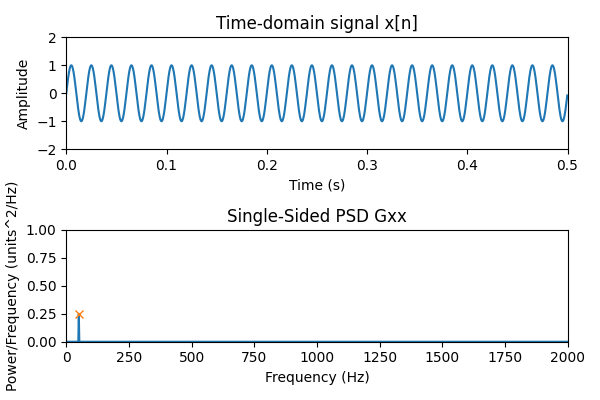

In [103]:
fs = 4000   # let's assume some sampling frequency in Hz
T = 0.5 # duration of the signal in seconds
t = np.arange(0, T, 1/fs) # time array

# This is a function to compute the PSD
def psd(x,fs, psdtype):

    """
    This computes the double sided (Sxx) or single sided (Gxx) power spectral density (PSD)
    from a time-domain signal x. It does not include a correction for a window.
    
    Arguments:
        x       - time domain signal
        fs      - sampling frequency
        psdtype - 'Single' for Gxx, 'Double' for Sxx
        
    Returns:
        freq  - vector with the frequencies
        PSD   - Either Gxx or Sxx
        
    """
    if len(x) % 2 != 0: x = x[:-1] # This ensures that x has an even number of samples
    N = len(x)
    dt = 1/fs
    T = N*dt
    X = np.fft.fft(x)*dt    # Linear Spectrum (need to multiply by dt)
    Sxx = (1/T)*(abs(X)**2) # Double-Sided PSD
     # Frequencies
    
    if psdtype == 'Double':
        PSD = Sxx # Double-Sided PSD
        freq = np.fft.fftfreq(N, d=dt)
        
    elif psdtype =='Single':
        Gxx = Sxx[0:N//2 + 1].copy()
        Gxx[1:-1] = 2*Gxx[1:-1] # Single-Sided PSD
        PSD = Gxx
        freq = np.fft.rfftfreq(N, d=dt)
        
    else:
        print("Let psd = 'Single' or psd ='Double' ")
    
    return PSD,freq

fig, ax = plt.subplots(2,1, figsize=(6,4))
    
timeplot, = ax[0].plot([], [])
ax[0].set_title('Time-domain signal x[n]')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')
ax[0].set_xlim([0, T])
ax[0].set_ylim([-2,2])

psdplot, = ax[1].plot([], [])
psdplot_max, = ax[1].plot([], [],'-x')
ax[1].set_title('Single-Sided PSD Gxx')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Power/Frequency (units^2/Hz)')
ax[1].set_xlim([0, fs/2])
ax[1].set_ylim([0, 1])


# Interactive plot to show the RMS computation with different sine waves
def interactive_psd(f1=50, A1=1,):
	
    fig.canvas.draw_idle()
    
    # Create sine wave
    x = A1*np.sin(2*np.pi*f1*t) 

    # Compute the single-sided PSD
    Gxx, fG = psd(x, fs, 'Single')
    df = fG[1] - fG[0]  # equivalent to fs/N, but that was already computed in the function

    Gxx_max = np.max(Gxx) # maximum value of Gxx
    freq_Gxx_max = fG[np.argmax(Gxx)] # frequency at which max occurs

    # Update time-domain plot
    timeplot.set_data(t, x)
    
    # Update PSD plot
    psdplot.set_data(fG, Gxx)
    psdplot_max.set_data(freq_Gxx_max, Gxx_max)

    # play audio
    IPython.display.display(Audio(x.T, rate=fs, autoplay=False))
    
    # Checking the energy equivalence
    print("Checking the energy equivalence:")
    print("Mean-square of x[n], 1/N*sum(x[n]^2) =", np.mean(x**2))
    print("Gxx * df =", np.sum(Gxx)* df)
    # RMS values
    print("------------------------")
    print("Computing the RMS values in time and freq domain:")
    print("RMS of x[n] using the time-domain signal, sqrt(1/N*sum(x[n]^2)) =", np.sqrt(np.mean(x**2)))
    print("RMS of x[n] using the PSD sqrt(Gxx_max*df) =", np.sqrt(Gxx_max*df))
    
    
plt.tight_layout()
    
    
print("Adjust the frequency and amplitude of the sine wave using the sliders below")
interact(interactive_psd, f1=(20, 500, 10), A1=(0.1, 2, 0.1))


### Frame-by-frame frequency analysis

So far, we have been analyzing one *frame* of our audio signal, i.e., a segment of $N$ samples. In situations where we have a long recording, if there are time-varying frequency components, then applying the PSD to a single frame consisting of all the samples from the entire recording will be insufficient to reveal this temporal variation. We will discuss this in further detail in the following notebook on [time-frequency analysis](https://randyaliased.github.io/acspjbook/main/fundamental/08_Time_Freq_Analysis.html), but I thought it was nevertheless instructive to make an interactive plot showing how we can analyze a long signal in shorter frame segments, progressing through the entire signal. 

In the following, we analyze once again the vocal sample (consisting of $N$ samples) but frame by frame, where the length of each frame consists of $P < N$ samples. What's important to note here is that the choice of $P$ now dictates the frequency resolution, $\Delta f$ such that $\Delta f = f_s/P$. At the same time, the choice of $P$ also dictates the temporal resolution as larger values of $P$  obscure fast time-varying details. Hence there is an inherent time-frequency resolution tradeoff which we'll encounter in a subsequent notebook. For now have some fun with the following plot. Observe how the PSD shows the relative power of the harmonic content of the voice changing over time in relation to what you hear. We can see that the fundamental frequency is decreasing, which we should expect as the vocal line descends in pitch. 

In [ ]:
# Read in the waveform once again
yy, fs = await read_wav_from_url(vocal_sample) # read in the vocal sample and get its sampling frequency

# Frame parameters - Change the frame_size to change the value of P 

frame_size=0.3 		     # Frame size in seconds
hop_size=frame_size/2    # This is an overlap of frames. This value is such that the next frame starts at the midpoint of the previous frame.
P = int(frame_size * fs) # Frame length in samples
hop_len   = int(hop_size * fs) # Hop length in samples
df = fs/P  # the frequency bin spacing

print("Frame length (s) = ",frame_size)
print("Frame size, P = ",P)
print("Freq. resolution, df = fs/P = ",df)


# Putting the PSD function once again (in case you did not run the previous cell)
def psd(x,fs, psdtype):

    """
    This computes the double sided (Sxx) or single sided (Gxx) power spectral density (PSD)
    from a time-domain signal x. It does not include a correction for a window.
    
    Arguments:
        x       - time domain signal
        fs      - sampling frequency
        psdtype - 'Single' for Gxx, 'Double' for Sxx
        
    Returns:
        freq  - vector with the frequencies
        PSD   - Either Gxx or Sxx
        
    """
    if len(x) % 2 != 0: x = x[:-1] # This ensures that x has an even number of samples
    N = len(x)
    dt = 1/fs
    T = N*dt
    X = np.fft.fft(x)*dt    # Linear Spectrum (need to multiply by dt)
    Sxx = (1/T)*(abs(X)**2) # Double-Sided PSD
     # Frequencies
    
    if psdtype == 'Double':
        PSD = Sxx # Double-Sided PSD
        freq = np.fft.fftfreq(N, d=dt)
        
    elif psdtype =='Single':
        Gxx = Sxx[0:N//2 + 1].copy()
        Gxx[1:-1] = 2*Gxx[1:-1] # Single-Sided PSD
        PSD = Gxx
        freq = np.fft.rfftfreq(N, d=dt)
        
    else:
        print("Let psd = 'Single' or psd ='Double' ")
    
    return PSD,freq



fig, axes = plt.subplots(2,1, figsize=(6,4))
waveform, = axes[0].plot([], [])
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amp')
axes[0].set_xlim([0, frame_size])
axes[0].set_ylim([-0.6, 0.6])

psdplot, = axes[1].plot([], [])
axes[1].set_xlim([0, fs/2])
axes[1].set_ylim([-120, -20])
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('dB/Hz')


# number of complete frames we can fit
n_frames = 1 + (len(yy) - P) // hop_len

def update(i=0):
	
    
    
    start = i * hop_len
    frame = yy[start:start+P]
    t = np.arange(0,P/fs,1/fs)
    # print("Start time of frame (s): ",start/fs)
    
    # Get PSD
    Gxx, fG = psd(frame, fs, 'Single')
    
    waveform.set_data(t, frame)
    psdplot.set_data(fG, 10*np.log10(Gxx))
	
    fig.canvas.draw_idle()
    IPython.display.display(Audio(frame.T, rate=fs,normalize=True))

print('Move the slider to analyze the frames of the signal')
interact(update, i=(0,n_frames,1))
plt.tight_layout()
plt.show()




